### Libraries:

In [1]:
#Core:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
import requests
import warnings
warnings.filterwarnings("ignore")

#Data preprocessing:

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Machine Learning:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


### Import Data:

In [2]:
url = 'https://github.com/manugaco/ML_User_Cases/blob/master/Datasets/Customers/Customer_Churn.zip?raw=true'
zip = ZipFile(BytesIO(requests.get(url).content), 'r')
df = pd.read_csv(zip.open(zip.namelist()[0]), low_memory=False, encoding="ISO-8859-1")

### Auxiliary functions:

In [3]:
def desc_var(data, name, isid=False):
    print('Exploring column:', name)
    if isid==True:
        print('Number of duplicated entries in the variable '+ str(name) + ' = ' + str(data[name].duplicated().sum()))
    print('Number of distinct entries in the variable '+ str(name) + ' = ' + str(data[name].nunique()))
    print('Number of missing entries in the variable '+ str(name) + ' = ' + str(data[name].isnull().sum()))
    print('The data type of the column ' + str(name) + ' is ' + str(datatypes[name]))


def desc_num_var(data, name):
    print('Exploring numberic variable: ', name)
    print(data[name].describe())


def feat_sel(df_features, target):

    X = df_features.values
    Y = target.values
    
    # feature extraction
    model = ExtraTreesClassifier(n_estimators=10)
    model.fit(X, Y)
    importances = model.feature_importances_
    imp_bool = importances > importances.mean()
    imp_cols = [df_features.columns[i] for i in range(len(imp_bool)) if imp_bool[i] == True]
    output =  df_features[imp_cols]
    
    return(output)

def drop_cor(tabla, threshold):
    
    cor_mat = tabla.corr().abs()
    up = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))
    to_drop = [column for column in up.columns if any(up[column] > threshold)]
    output = tabla.drop(to_drop, axis=1)
    return(output)

def balance_data(X, y, under_s, over_s, balan = True):
    
    if(balan == True):
        if((under_s[0] == True) and (over_s[0] == True)):
            under = RandomUnderSampler(sampling_strategy=under_s[1])
            over = SMOTE(sampling_strategy=over_s[1])
            steps = [('u', under), ('o', over)]
        elif((under_s[0] == True) and (over_s[0] == False)):
            under = RandomUnderSampler(sampling_strategy=under_s[1])
            steps = [('u', under)]
        elif((under_s[0] == False) and (over_s[0] == True)):
            over = SMOTE(sampling_strategy=over_s[1])
            steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        X, y = pipeline.fit_resample(X, y)
    
    return(y, X)


### Exploratory Data Analysis:

#### Dataset overview

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Dataset shape

In [5]:
print('The dataset shape is: ', df.shape)

The dataset shape is:  (7043, 21)


#### Variable exploration: Univariate EDA

In [6]:
colnames = df.columns
datatypes = df.dtypes

##### Customer ID:

In [7]:
desc_var(df, colnames[0], isid=True)

Exploring column: customerID
Number of duplicated entries in the variable customerID = 0
Number of distinct entries in the variable customerID = 7043
Number of missing entries in the variable customerID = 0
The data type of the column customerID is object


In [8]:
df = df.reset_index(drop=True).set_index('customerID')

The id variable has no duplicated nor missing entries. This variable is set as index.

##### Gender:

In [9]:
desc_var(df, colnames[1])

Exploring column: gender
Number of distinct entries in the variable gender = 2
Number of missing entries in the variable gender = 0
The data type of the column gender is object


In [10]:
df[colnames[1]].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [11]:
pd.crosstab(df[colnames[1]], df['Churn'])

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


The variable gender is a good candidate to be excluded from the model, because it does not discriminate between classes.

##### Senior Citizen:

In [12]:
desc_var(df, colnames[2])

Exploring column: SeniorCitizen
Number of distinct entries in the variable SeniorCitizen = 2
Number of missing entries in the variable SeniorCitizen = 0
The data type of the column SeniorCitizen is int64


In [13]:
df[colnames[2]].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [14]:
pd.crosstab(df[colnames[2]], df['Churn'])

Churn,No,Yes
SeniorCitizen,,
0,4508,1393
1,666,476


It is clear that non senior citizens tend to leave the company more than senior citizens. That can be because young people usually look for cheaper contracts and expend less in bills.

##### Partner:

In [15]:
desc_var(df, colnames[3])

Exploring column: Partner
Number of distinct entries in the variable Partner = 2
Number of missing entries in the variable Partner = 0
The data type of the column Partner is object


In [16]:
df[colnames[3]].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [17]:
pd.crosstab(df[colnames[3]], df['Churn'])

Churn,No,Yes
Partner,,
No,2441,1200
Yes,2733,669


Customers with couple tend to leave the company less than customers without partner. This could be caused because single customers tend to save more money than a couple.

##### Dependents:

In [18]:
desc_var(df, colnames[4])

Exploring column: Dependents
Number of distinct entries in the variable Dependents = 2
Number of missing entries in the variable Dependents = 0
The data type of the column Dependents is object


In [19]:
df[colnames[4]].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [20]:
pd.crosstab(df[colnames[4]], df['Churn'])

Churn,No,Yes
Dependents,,
No,3390,1543
Yes,1784,326


Customers with dependents tend to leave less the company than those without.

##### Tenure:

In [21]:
desc_var(df, colnames[5])

Exploring column: tenure
Number of distinct entries in the variable tenure = 73
Number of missing entries in the variable tenure = 0
The data type of the column tenure is int64


In [22]:
desc_num_var(df, colnames[5])

Exploring numberic variable:  tenure
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


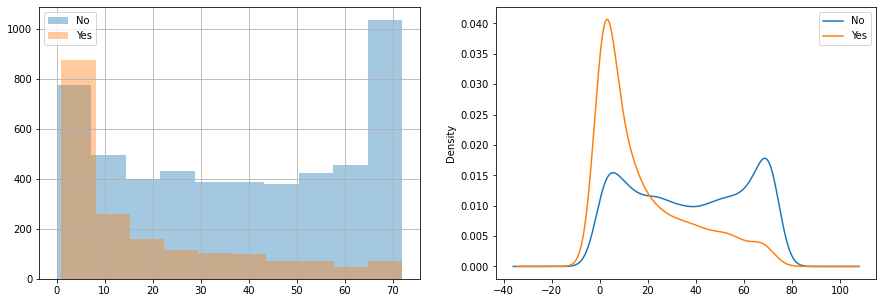

In [23]:
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
df.groupby("Churn").tenure.plot(kind='kde', ax=axs[1], legend=True)
df.groupby("Churn").tenure.hist(alpha=0.4, ax=axs[0], legend=True)
plt.show()

Customers with lower values on the variable tenure tend to leave the company more than those with higher value in this variable.

##### Phone Service:

In [24]:
desc_var(df, colnames[6])

Exploring column: PhoneService
Number of distinct entries in the variable PhoneService = 2
Number of missing entries in the variable PhoneService = 0
The data type of the column PhoneService is object


In [25]:
df[colnames[6]].value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [26]:
pd.crosstab(df[colnames[6]], df['Churn'])

Churn,No,Yes
PhoneService,,
No,512,170
Yes,4662,1699


Customer with phone service tend to leave the company more than those without phone service.

##### MultipleLines:

In [27]:
desc_var(df, colnames[7])

Exploring column: MultipleLines
Number of distinct entries in the variable MultipleLines = 3
Number of missing entries in the variable MultipleLines = 0
The data type of the column MultipleLines is object


In [28]:
df[colnames[7]].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [29]:
pd.crosstab(df[colnames[7]], df['Churn'])

Churn,No,Yes
MultipleLines,,
No,2541,849
No phone service,512,170
Yes,2121,850


Customers with a single line or multiple lines does not tend to leave the company significantly different from each other. However, as previously seen in the variable phone service, the behaviour is significantly different. This variable is a good candidate to be excluded from the model.

##### Internet Service:

In [30]:
desc_var(df, colnames[8])

Exploring column: InternetService
Number of distinct entries in the variable InternetService = 3
Number of missing entries in the variable InternetService = 0
The data type of the column InternetService is object


In [31]:
df[colnames[8]].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [32]:
pd.crosstab(df[colnames[8]], df['Churn'])

Churn,No,Yes
InternetService,,
DSL,1962,459
Fiber optic,1799,1297
No,1413,113


Custmers with fiber optic tend to leave the company more than those with DSL and without internet service.

##### Online Security:

In [33]:
desc_var(df, colnames[9])

Exploring column: OnlineSecurity
Number of distinct entries in the variable OnlineSecurity = 3
Number of missing entries in the variable OnlineSecurity = 0
The data type of the column OnlineSecurity is object


In [34]:
df[colnames[9]].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

In [35]:
pd.crosstab(df[colnames[9]], df['Churn'])

Churn,No,Yes
OnlineSecurity,,
No,2037,1461
No internet service,1413,113
Yes,1724,295


Customers with online security (or without internet service) stay more than those without.

##### Online Backup:

In [36]:
desc_var(df, colnames[10])

Exploring column: OnlineBackup
Number of distinct entries in the variable OnlineBackup = 3
Number of missing entries in the variable OnlineBackup = 0
The data type of the column OnlineBackup is object


In [37]:
df[colnames[10]].value_counts()

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

In [38]:
pd.crosstab(df[colnames[10]], df['Churn'])

Churn,No,Yes
OnlineBackup,,
No,1855,1233
No internet service,1413,113
Yes,1906,523


Customers with online backup service tend to leave less the company than those without internet or with online backup.

##### Device Protection:

In [39]:
desc_var(df, colnames[11])

Exploring column: DeviceProtection
Number of distinct entries in the variable DeviceProtection = 3
Number of missing entries in the variable DeviceProtection = 0
The data type of the column DeviceProtection is object


In [40]:
df[colnames[11]].value_counts()

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

In [41]:
pd.crosstab(df[colnames[11]], df['Churn'])

Churn,No,Yes
DeviceProtection,,
No,1884,1211
No internet service,1413,113
Yes,1877,545


Customers without device protection tend to leave the company more than those without internet service or with device protection.

##### Tech Support:

In [42]:
desc_var(df, colnames[12])

Exploring column: TechSupport
Number of distinct entries in the variable TechSupport = 3
Number of missing entries in the variable TechSupport = 0
The data type of the column TechSupport is object


In [43]:
df[colnames[12]].value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

In [44]:
pd.crosstab(df[colnames[12]], df['Churn'])

Churn,No,Yes
TechSupport,,
No,2027,1446
No internet service,1413,113
Yes,1734,310


Customers with technical support tend to leave less the company than those without internet or this service.

##### StreamingTV:

In [45]:
desc_var(df, colnames[13])

Exploring column: StreamingTV
Number of distinct entries in the variable StreamingTV = 3
Number of missing entries in the variable StreamingTV = 0
The data type of the column StreamingTV is object


In [46]:
df[colnames[13]].value_counts()

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

In [47]:
pd.crosstab(df[colnames[13]], df['Churn'])

Churn,No,Yes
StreamingTV,,
No,1868,942
No internet service,1413,113
Yes,1893,814


Streaming TV does not seem to be discriminating the Churn variable significantly. This variable is a good candidate to be excluded from the model.

##### Streaming movies:

In [48]:
desc_var(df, colnames[14])

Exploring column: StreamingMovies
Number of distinct entries in the variable StreamingMovies = 3
Number of missing entries in the variable StreamingMovies = 0
The data type of the column StreamingMovies is object


In [49]:
df[colnames[14]].value_counts()

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

In [50]:
pd.crosstab(df[colnames[14]], df['Churn'])

Churn,No,Yes
StreamingMovies,,
No,1847,938
No internet service,1413,113
Yes,1914,818


Again, the variable streaming movies does not make significant differences by controling with churn. This variable is a good candidate to be excluded from the model.

##### Contract:

In [51]:
desc_var(df, colnames[15])

Exploring column: Contract
Number of distinct entries in the variable Contract = 3
Number of missing entries in the variable Contract = 0
The data type of the column Contract is object


In [52]:
df[colnames[15]].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [53]:
pd.crosstab(df[colnames[15]], df['Churn'])

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


Customers with contract month-to-month tend to leave the company significantly more than the rest of the contract types.

##### Paperless Billing:

In [54]:
desc_var(df, colnames[16])

Exploring column: PaperlessBilling
Number of distinct entries in the variable PaperlessBilling = 2
Number of missing entries in the variable PaperlessBilling = 0
The data type of the column PaperlessBilling is object


In [55]:
df[colnames[16]].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

In [56]:
pd.crosstab(df[colnames[16]], df['Churn'])

Churn,No,Yes
PaperlessBilling,,
No,2403,469
Yes,2771,1400


Customers being billed paperless tend to leave more than those without.

##### Payment Method:

In [57]:
desc_var(df, colnames[17])

Exploring column: PaymentMethod
Number of distinct entries in the variable PaymentMethod = 4
Number of missing entries in the variable PaymentMethod = 0
The data type of the column PaymentMethod is object


In [58]:
df[colnames[17]].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [59]:
pd.crosstab(df[colnames[17]], df['Churn'])

Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),1286,258
Credit card (automatic),1290,232
Electronic check,1294,1071
Mailed check,1304,308


In [60]:
df[colnames[17]] = np.where(df[colnames[17]] == 'Electronic check', 'Elec_check', 'Non_elec_check')

Customers with electronic check payment method tend to leave more the company than the rest of the classes. This variable can be readjust to a binary (electronic check/non-electronic check).

In [61]:
pd.crosstab(df[colnames[17]], df['Churn'])

Churn,No,Yes
PaymentMethod,,
Elec_check,1294,1071
Non_elec_check,3880,798


##### Monthly charges:

In [62]:
desc_var(df, colnames[18])

Exploring column: MonthlyCharges
Number of distinct entries in the variable MonthlyCharges = 1585
Number of missing entries in the variable MonthlyCharges = 0
The data type of the column MonthlyCharges is float64


In [63]:
desc_num_var(df, colnames[18])

Exploring numberic variable:  MonthlyCharges
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


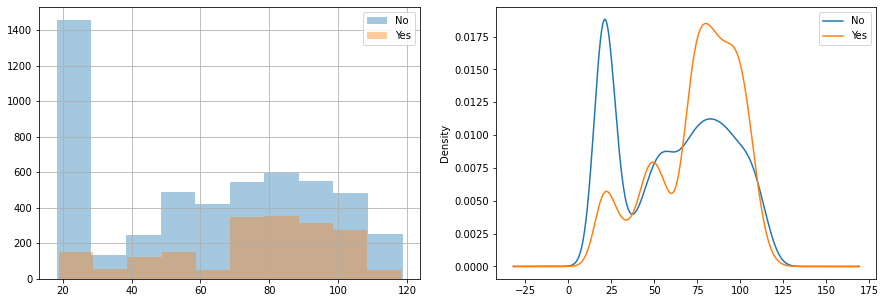

In [64]:
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
df.groupby("Churn")[colnames[18]].plot(kind='kde', ax=axs[1], legend=True)
df.groupby("Churn")[colnames[18]].hist(alpha=0.4, ax=axs[0], legend=True)
plt.show()

Customers with low charges tend to leave less the company than those with high monthly expenses.

##### Total Charges:

In [65]:
desc_var(df, colnames[19])

Exploring column: TotalCharges
Number of distinct entries in the variable TotalCharges = 6531
Number of missing entries in the variable TotalCharges = 0
The data type of the column TotalCharges is object


In [66]:
df[colnames[19]] = np.where(df[colnames[19]] == ' ', np.nan, df[colnames[19]])
df[colnames[19]] = df[colnames[19]].astype(np.float64)

In [67]:
desc_var(df, colnames[19])

Exploring column: TotalCharges
Number of distinct entries in the variable TotalCharges = 6530
Number of missing entries in the variable TotalCharges = 11
The data type of the column TotalCharges is object


In [68]:
desc_num_var(df, colnames[19])

Exploring numberic variable:  TotalCharges
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


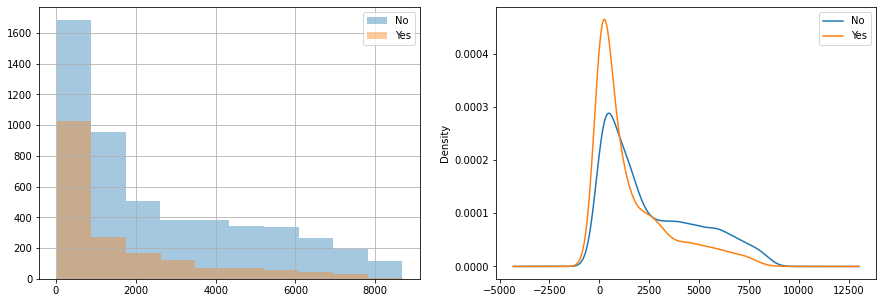

In [69]:
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
df.groupby("Churn")[colnames[19]].plot(kind='kde', ax=axs[1], legend=True)
df.groupby("Churn")[colnames[19]].hist(alpha=0.4, ax=axs[0], legend=True)
plt.show()

The variable total charges does not seem to make any differences on churn rate. This is a candidate to be excluded.

##### Churn (Target):

In [70]:
desc_var(df, colnames[20])

Exploring column: Churn
Number of distinct entries in the variable Churn = 2
Number of missing entries in the variable Churn = 0
The data type of the column Churn is object


In [71]:
df[colnames[20]].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [72]:
df[colnames[20]] = np.where(df[colnames[20]] == 'Yes', 1, 0)

In [73]:
df[colnames[20]].value_counts().reset_index().apply(lambda x:x/x.sum())

,index,Churn
0,0.0,0.73463
1,1.0,0.26537


The target variable is unbalanced it could be interesting to resample the dataset to balance it.

#### Missing values imputation:

In [74]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [75]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [76]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

##### Candidate variables to be removed after univariate EDA:

In [77]:
#gender, multiple lines, streaming TV, streaming movies, total charges. 
df = df.drop(['gender', 'MultipleLines', 'StreamingTV', 'StreamingMovies', 'TotalCharges'], axis=1)

##### One hot encoding:

In [78]:
df_feat = pd.concat([
        pd.get_dummies(df['SeniorCitizen'], prefix='Seniority', drop_first=True),
        pd.get_dummies(df['Partner'], prefix='Partner', drop_first=True),
        pd.get_dummies(df['Dependents'], prefix='Dependents', drop_first=True),
        df['tenure'],
        pd.get_dummies(df['PhoneService'], prefix='PhoneService', drop_first=True),
        pd.get_dummies(df['InternetService'], prefix='InternetService', drop_first=True),
        pd.get_dummies(df['OnlineSecurity'], prefix='OnlineSecurity', drop_first=True),
        pd.get_dummies(df['OnlineBackup'], prefix='OnlineBackup', drop_first=True),
        pd.get_dummies(df['DeviceProtection'], prefix='DeviceProtection', drop_first=True), 
        pd.get_dummies(df['TechSupport'], prefix='TechSupport', drop_first=True),
        pd.get_dummies(df['Contract'], prefix='Contract', drop_first=True),
        pd.get_dummies(df['PaperlessBilling'], prefix='PaperlessBilling', drop_first=True),
        pd.get_dummies(df['PaymentMethod'], prefix='PaymentMethod', drop_first=True),
        df['MonthlyCharges'],
        ], axis=1)

In [79]:
df_feat.head()

,Seniority_1,Partner_Yes,Dependents_Yes,tenure,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Non_elec_check,MonthlyCharges
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,29.85
5575-GNVDE,0,0,0,34,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,56.95
3668-QPYBK,0,0,0,2,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,53.85
7795-CFOCW,0,0,0,45,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,42.30
9237-HQITU,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,70.70


##### Feature Engineering:

In [80]:
poly = PolynomialFeatures(2)
ls_features = poly.fit_transform(df_feat)
df_featured = pd.DataFrame(ls_features)
df_featured.columns = poly.get_feature_names(input_features=df_feat.columns)
df_featured.index = df_feat.index
df_featured.drop('1', axis=1, inplace=True)

In [81]:
df_featured.head()

,Seniority_1,Partner_Yes,Dependents_Yes,tenure,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,...,Contract_Two year^2,Contract_Two year PaperlessBilling_Yes,Contract_Two year PaymentMethod_Non_elec_check,Contract_Two year MonthlyCharges,PaperlessBilling_Yes^2,PaperlessBilling_Yes PaymentMethod_Non_elec_check,PaperlessBilling_Yes MonthlyCharges,PaymentMethod_Non_elec_check^2,PaymentMethod_Non_elec_check MonthlyCharges,MonthlyCharges^2
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,29.85,0.0,0.00,891.0225
5575-GNVDE,0.0,0.0,0.0,34.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,56.95,3243.3025
3668-QPYBK,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,53.85,1.0,53.85,2899.8225
7795-CFOCW,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,42.30,1789.2900
9237-HQITU,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,70.70,0.0,0.00,4998.4900


#### Feature Selection:

##### Feature Importance:

In [82]:
np.random.seed(111)

df_feat_imp = feat_sel(df_featured, df['Churn'])

In [83]:
df_feat_imp.head()

,tenure,InternetService_Fiber optic,OnlineBackup_No internet service,OnlineBackup_Yes,Contract_One year,Contract_Two year,MonthlyCharges,Seniority_1 tenure,Seniority_1 MonthlyCharges,Partner_Yes tenure,...,TechSupport_Yes MonthlyCharges,Contract_One year^2,Contract_One year MonthlyCharges,Contract_Two year^2,Contract_Two year PaymentMethod_Non_elec_check,Contract_Two year MonthlyCharges,PaperlessBilling_Yes MonthlyCharges,PaymentMethod_Non_elec_check^2,PaymentMethod_Non_elec_check MonthlyCharges,MonthlyCharges^2
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1.0,0.0,0.0,1.0,0.0,0.0,29.85,0.0,0.0,1.0,...,0.0,0.0,0.00,0.0,0.0,0.0,29.85,0.0,0.00,891.0225
5575-GNVDE,34.0,0.0,0.0,0.0,1.0,0.0,56.95,0.0,0.0,0.0,...,0.0,1.0,56.95,0.0,0.0,0.0,0.00,1.0,56.95,3243.3025
3668-QPYBK,2.0,0.0,0.0,1.0,0.0,0.0,53.85,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,53.85,1.0,53.85,2899.8225
7795-CFOCW,45.0,0.0,0.0,0.0,1.0,0.0,42.30,0.0,0.0,0.0,...,42.3,1.0,42.30,0.0,0.0,0.0,0.00,1.0,42.30,1789.2900
9237-HQITU,2.0,1.0,0.0,0.0,0.0,0.0,70.70,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,70.70,0.0,0.00,4998.4900


##### Correlated features:

In [84]:
df_feat_clean = drop_cor(df_feat_imp, 0.95)

In [85]:
df_feat_clean.head()

,tenure,InternetService_Fiber optic,OnlineBackup_No internet service,OnlineBackup_Yes,Contract_One year,Contract_Two year,MonthlyCharges,Seniority_1 tenure,Seniority_1 MonthlyCharges,Partner_Yes tenure,...,OnlineSecurity_Yes^2,OnlineSecurity_Yes MonthlyCharges,DeviceProtection_Yes MonthlyCharges,TechSupport_Yes MonthlyCharges,Contract_One year MonthlyCharges,Contract_Two year PaymentMethod_Non_elec_check,Contract_Two year MonthlyCharges,PaperlessBilling_Yes MonthlyCharges,PaymentMethod_Non_elec_check^2,PaymentMethod_Non_elec_check MonthlyCharges
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1.0,0.0,0.0,1.0,0.0,0.0,29.85,0.0,0.0,1.0,...,0.0,0.00,0.00,0.0,0.00,0.0,0.0,29.85,0.0,0.00
5575-GNVDE,34.0,0.0,0.0,0.0,1.0,0.0,56.95,0.0,0.0,0.0,...,1.0,56.95,56.95,0.0,56.95,0.0,0.0,0.00,1.0,56.95
3668-QPYBK,2.0,0.0,0.0,1.0,0.0,0.0,53.85,0.0,0.0,0.0,...,1.0,53.85,0.00,0.0,0.00,0.0,0.0,53.85,1.0,53.85
7795-CFOCW,45.0,0.0,0.0,0.0,1.0,0.0,42.30,0.0,0.0,0.0,...,1.0,42.30,42.30,42.3,42.30,0.0,0.0,0.00,1.0,42.30
9237-HQITU,2.0,1.0,0.0,0.0,0.0,0.0,70.70,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.00,0.0,0.0,70.70,0.0,0.00


In [86]:
X = df_feat_clean
y = df['Churn']

y, X = balance_data(X, y, (True, 0.55), (False, 0.9), balan = True)

In [87]:
y.value_counts().reset_index().apply(lambda x:x/x.sum())

,index,Churn
0,0.0,0.645149
1,1.0,0.354851


##### Train test split:

In [88]:
seed = 111
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [89]:

grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [90]:
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5)
logreg_cv.fit(X_train, y_train)

print("tuned hyper-parameters : ", logreg_cv.best_params_)

tuned hyper-parameters :  {'C': 10.0, 'penalty': 'l2'}


##### Train metrics:

In [91]:
clf = LogisticRegression(C=logreg_cv.best_params_.get('C'), 
                         penalty=logreg_cv.best_params_.get('penalty'))
clf.fit(X_train, y_train)
y_hat_train = clf.predict(X_train)

In [92]:
print('Accuracy score on train set:', round(accuracy_score(y_hat_train, y_train),4)*100)
print('Recall score on train set:',round(recall_score(y_hat_train, y_train),4)*100)
print('Precision score on train set:',round(precision_score(y_hat_train, y_train),3)*100)
print('F1 score on train set:',round(f1_score(y_hat_train, y_train),3)*100)

Accuracy score on train set: 77.57
Recall score on train set: 68.58999999999999
Precision score on train set: 68.2
F1 score on train set: 68.4


In [93]:
pd.crosstab(y_hat_train, y_train)

Churn,0,1
row_0,,
0,2246,477
1,468,1022


##### Test metrics:

In [94]:
y_hat_test = clf.predict(X_test)

In [95]:
print('Accuracy score on test set:', round(accuracy_score(y_hat_test, y_test),4)*100)
print('Recall score on test set:',round(recall_score(y_hat_test, y_test),4)*100)
print('Precision score on test set:',round(precision_score(y_hat_test, y_test),3)*100)
print('F1 score on test set:',round(f1_score(y_hat_test, y_test),3)*100)

Accuracy score on test set: 76.47
Recall score on test set: 65.8
Precision score on test set: 68.60000000000001
F1 score on test set: 67.2


In [96]:
pd.crosstab(y_hat_test, y_test)

Churn,0,1
row_0,,
0,552,116
1,132,254


##### Visualizing distributions of predictions on train and test (Calibration):

In [97]:
prob_y_train = clf.predict_proba(X_train)
prob_y_test = clf.predict_proba(X_test)
df_train_preds = pd.concat([pd.DataFrame(y_train).reset_index(drop=True), pd.DataFrame(prob_y_train)], axis=1).rename(columns={1:'y_hat'})
df_test_preds = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), pd.DataFrame(prob_y_test)], axis=1).rename(columns={1:'y_hat'})

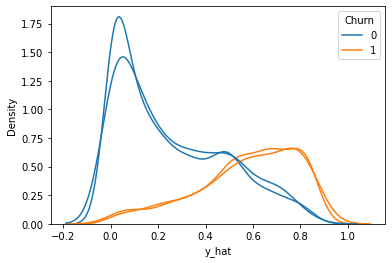

In [98]:
sns.kdeplot(data=df_train_preds, x='y_hat', hue='Churn')
sns.kdeplot(data=df_test_preds, x='y_hat', hue='Churn')
plt.show()

In [99]:
below = norm.cdf(x = 0, loc = df_train_preds['y_hat'], scale = 0.10)
above = 1- norm.cdf(x = 1, loc = df_train_preds['y_hat'], scale = 0.10)
df_train_preds['edgeweight'] = 1 / (1 - below - above)
below = norm.cdf(x = 0, loc = df_test_preds['y_hat'], scale = 0.10)
above = 1- norm.cdf(x = 1, loc = df_test_preds['y_hat'], scale = 0.10)
df_test_preds['edgeweight'] = 1 / (1 - below - above)

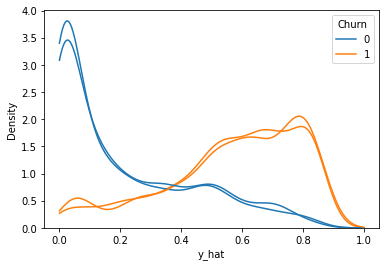

In [100]:
sns.kdeplot(data=df_train_preds, x = "y_hat", hue = "Churn", 
            common_norm = False, bw_method = 0.2,
            clip = (0,1), weights = 'edgeweight')
sns.kdeplot(data=df_test_preds, x="y_hat", hue = "Churn", 
            common_norm = False, bw_method = 0.2,
            clip = (0,1), weights = 'edgeweight')
plt.show()

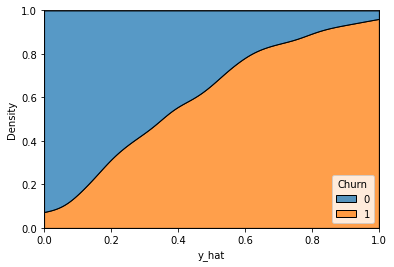

In [101]:
cum_plot = sns.kdeplot(data = df_train_preds, x = "y_hat", hue = "Churn", 
                common_norm = False, bw_method = 0.2,
                clip = (0,1), weights = 'edgeweight', 
                multiple = "fill", legend = True)
cum_plot.legend_._set_loc(4)
plt.show()

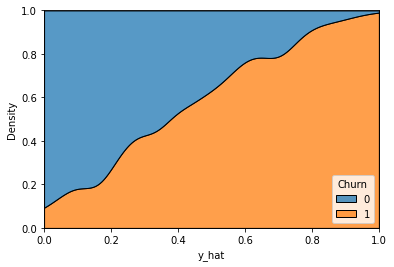

In [102]:
cum_plot = sns.kdeplot(data = df_test_preds, x = "y_hat", hue = "Churn", 
                common_norm = False, bw_method = 0.2,
                clip = (0,1), weights = 'edgeweight', 
                multiple = "fill", legend = True)
cum_plot.legend_._set_loc(4)
plt.show()